In [1]:
import os 
import zipfile 

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torchvision
import torchvision.transforms as transforms

import glob
from PIL import Image

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from IPython.display import clear_output
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sns

from keras import backend as K

from sklearn.utils import resample

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
data_dir = "/images/"
metadata_path = "/HAM10000_metadata.csv"

In [4]:
#Lesion Dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
# Read metadata into dataframe
metadata = pd.read_csv(metadata_path)
skin_df = metadata

In [6]:
# Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob.glob(os.path.join(data_dir, '*.jpg'))}

In [7]:
#Create useful Columns - Images Path, Lesion Type and Lesion Categorical Code
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [8]:
# Lesion code dictionary
lesion_code_dict = pd.Series(skin_df.dx.values,index=skin_df.cell_type_idx).to_dict()

lesion_code_dict

{0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'nv', 5: 'mel', 6: 'vasc'}

In [9]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Actinic keratoses,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Actinic keratoses,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Actinic keratoses,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern,/content/drive/MyDrive/Colab Notebooks/images/...,Actinic keratoses,0


In [10]:
# Attach images to the skin_df Dataframe
temp_arr, count = [], 0
for path in tqdm(skin_df['path']):
  temp_arr.append(np.asarray( Image.open(path).resize((100,75)) ))
  count += 1
  if count % 10 == 0: clear_output()

skin_df['image'] = temp_arr

100%|██████████| 10015/10015 [43:39<00:00,  3.82it/s]


In [11]:
# Separate the dataframe into Features and Targets data
features = skin_df.drop(columns=['cell_type_idx','dx'],axis=1)
target = skin_df['cell_type_idx']

In [12]:
# Create First Train and Test sets
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=1)
print(x_train_o.shape)
print(y_train_o.shape)

(8012, 10)
(8012,)


In [13]:
# Create image arrays from the train and test sets
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

print(x_train.shape)
print(x_test.shape)

(8012, 75, 100, 3)
(2003, 75, 100, 3)


In [14]:
# Class distribution before data augmentation
train_value_counts = y_train_o.value_counts()
print(train_value_counts)
print(f'Total images: {train_value_counts.sum()}')

4    5378
5     891
2     871
1     418
0     266
6     110
3      78
Name: cell_type_idx, dtype: int64
Total images: 8012


In [15]:
# Data Augmentation
# Image data generator is used to generate the possible versions of data as given below.

dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10
    ) 

In [16]:
# For each lesion code != 4, get the indices in y_train_o.
# For the same indices in x_train_o, augment the image present in the row.
reset_y_train_o = y_train_o.reset_index(drop=True)
reset_index = reset_y_train_o.index

print(len(y_train_o))

8012


In [17]:
# The normalisation is done using the training set Mean and Std. Deviation as reference
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std

In [18]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [19]:
# Splitting training into Train and Validatation sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state=1)

# Reshaping the Images into 3 channels (RGB)
# height = 75, width = 100, canal = 3
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [20]:

input_shape = (75, 100, 3)
num_classes = 7

# Baseline CNN - 2

# After considering one input and one output per tensor
# Initializing CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64, (3,3), padding='Same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 100, 64)       1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 100, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 75, 100, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 50, 64)        2

In [21]:
# Define metrics 

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [22]:
# Define the optimizer
optimizer = Adam(learning_rate=0.001, 
                 beta_1=0.9, 
                 beta_2=0.999, 
                 # epsilon=None, 
                 decay=0.0, 
                 amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy", f1_m,precision_m, recall_m])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [23]:
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_validate = np.asarray(x_validate)
y_validate = np.asarray(y_validate)

In [24]:
# Fit the model
epochs = 25
batch_size = 10
history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/25
721/721 [==============================] - 52s 25ms/step - loss: 1.1487 - accuracy: 0.6214 - f1_m: 0.6004 - precision_m: 0.6887 - recall_m: 0.5387 - val_loss: 0.9314 - val_accuracy: 0.6958 - val_f1_m: 0.6259 - val_precision_m: 0.8744 - val_recall_m: 0.4904
Epoch 2/25
721/721 [==============================] - 17s 23ms/step - loss: 0.9372 - accuracy: 0.6702 - f1_m: 0.6543 - precision_m: 0.7781 - recall_m: 0.5717 - val_loss: 0.8560 - val_accuracy: 0.7070 - val_f1_m: 0.6850 - val_precision_m: 0.8122 - val_recall_m: 0.5962
Epoch 3/25
721/721 [==============================] - 17s 24ms/step - loss: 0.9012 - accuracy: 0.6777 - f1_m: 0.6570 - precision_m: 0.7855 - recall_m: 0.5720 - val_loss: 0.7709 - val_accuracy: 0.7170 - val_f1_m: 0.7224 - val_precision_m: 0.8185 - val_recall_m: 0.6514
Epoch 4/25
721/721 [==============================] - 17s 24ms/step - loss: 0.8787 - accuracy: 0.6805 - f1_m: 0.6638 - precision_m: 0.7790 - recall_m: 0.5848 - val_loss: 0.7612 - val_accuracy: 0.7

dict_keys(['loss', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m', 'lr'])
Accuracy: 0.7599167823791504
loss: 0.6516247987747192
f1_m: 0.7511606812477112
precision_m: 0.8396969437599182
recall_m: 0.6846056580543518


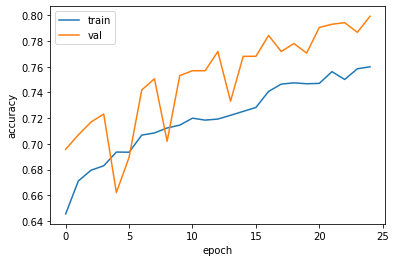

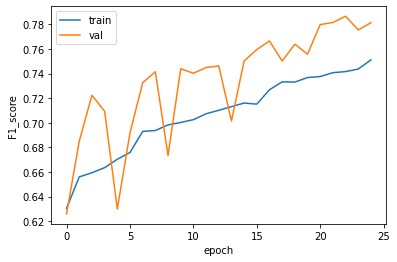

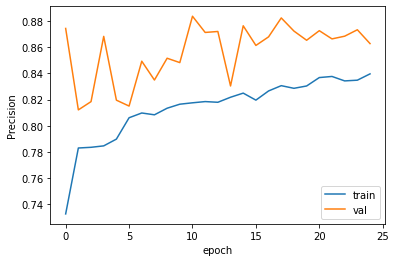

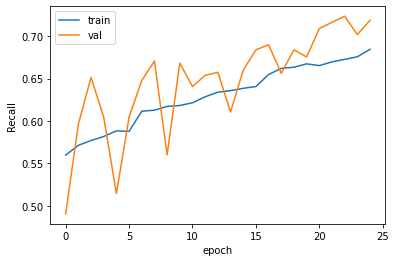

In [25]:
# plot graphs from history
print(history.history.keys())
print(f'Accuracy: {history.history["accuracy"][-1]}')
print(f'loss: {history.history["loss"][-1]}')
print(f'f1_m: {history.history["f1_m"][-1]}')
print(f'precision_m: {history.history["precision_m"][-1]}')
print(f'recall_m: {history.history["recall_m"][-1]}')

plt.plot(history.history["accuracy"], label='accuracy')
plt.plot(history.history["val_accuracy"], label='Validaion accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["f1_m"], label='F1_score')
plt.plot(history.history["val_f1_m"], label='Validaion F1_score')
plt.ylabel('F1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["precision_m"], label='Precision')
plt.plot(history.history["val_precision_m"], label='Validaion Precision')
plt.ylabel('Precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

plt.plot(history.history["recall_m"], label='Recall')
plt.plot(history.history["val_recall_m"], label='Validaion Recall')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [26]:
# Evaluate model
test_eval = model.evaluate(x_test, y_test, verbose=1, return_dict=True)
validation_eval = model.evaluate(x_validate, y_validate, verbose=1, return_dict=True)
# model.save("model.h5")

26/26 [==============================] - 0s 8ms/step - loss: 0.5645 - accuracy: 0.7993 - f1_m: 0.7814 - precision_m: 0.8628 - recall_m: 0.7188


In [27]:
for i, j in validation_eval.items():
    print(f'{i}: {j}')

loss: 0.5644752979278564
accuracy: 0.7992518544197083
f1_m: 0.7813800573348999
precision_m: 0.8628237247467041
recall_m: 0.71875


In [28]:
for i, j in test_eval.items():
    print(f'{i}: {j}')

loss: 0.6400395631790161
accuracy: 0.7608587145805359
f1_m: 0.7653648853302002
precision_m: 0.8476622700691223
recall_m: 0.7001879811286926


In [29]:
# Get predictions for plotting the confusion matrix
predictions = model.predict(x_test, verbose=1)

63/63 [==============================] - 1s 6ms/step


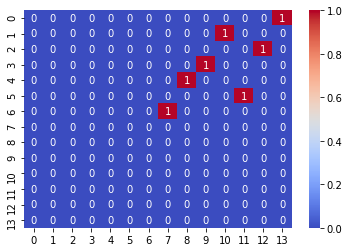

In [30]:
# Plot the confusion matrix
predictions = np.argmax(predictions, axis=0)
y_test = np.argmax(y_test, axis=0)

sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap = 'coolwarm', fmt='.0f')
plt.show()